In [14]:
from agent.agent import Agent
from agent.methods import training_evaluate, plot
from environment.env import Environment
import random
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import math
import os
from keras.models import load_model

data=pd.read_pickle('record')
dataset = pd.read_pickle(r'data\dqn3_1.pkl')
feature = ['sigmoid2_1','sigmoid2_2','sigmoid2_3','sigmoid2_4', 'sigmoid2_5',
                   'bias_10', 'bias_20', 'bias_60', 'bias_120', 'bias_240',
                   'acc_10', 'acc_20', 'acc_60', 'acc_120', 'acc_240', 
                   'rsv_10', 'rsv_20', 'rsv_60', 'rsv_120', 'rsv_240', ]
feature.extend(['Adj Open','Adj Close'])
dataset = dataset[feature]

train_year_start = '2018'
train_year_end = '2019'
train_data = dataset.loc[train_year_start:train_year_end].reset_index()
test_data = dataset.loc['2020'].reset_index()

state_size = len(train_data.columns) -3 +1 +2 #add one state hold, current profit rate, hold time,
state_size = (state_size,)
buffer_size = 40000

agent = Agent(buffer_size, state_size, )

env = Environment(train_data)
env2 = Environment(test_data)

In [26]:
agent.load('a1')
# data

C:\Users\user\Anaconda3\envs\dqn\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


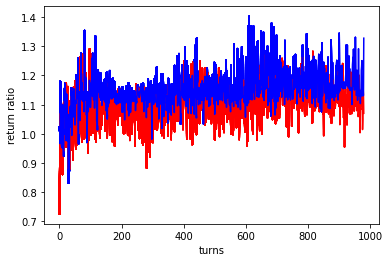

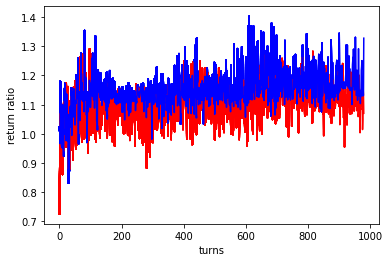

In [17]:
%matplotlib inline
import pylab as pl
from IPython import display

epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
gamma = 0.95
learning_rate = 0.0001

episode = 7000

agent.gamma = gamma
agent.learning_rate = learning_rate 
history_evaluate = {}

train_r = [] # train_with_random_search 
train_nr = [] # train_without_random_search

for i in tqdm_notebook(range(1000)):
    
    train_profit, done = 0, False
    episode +=1 
    
    state = env.reset()
    
   
    while not done:

        # select an action
        action = agent.act(state, epsilon,)
        next_state, reward, done, = env.step(action)
        train_profit += reward

        agent.remember_sumtree(state, action, reward, next_state, done) 
        agent.target_model_update(done, tau =0.1, type='transfer')
        epsilon = agent.epsilon_decay(epsilon, epsilon_min, epsilon_decay)   

        if agent.buffer.buffer.total() // batch_size > 0 :
            loss = agent.train_experience_replay_sumtree(batch_size)         
        
        state = next_state
                
    evaluate_profit, history_evaluate[i] = training_evaluate(agent, env,)    
    
    train_r.append(math.exp(train_profit))
    train_nr.append(math.exp(evaluate_profit))
    
    if i %20 != 0:
        continue
        
    pl.plot(train_r, color ='r',) 
    pl.plot(train_nr, color ='b',) 
    pl.xlabel('turns')
    pl.ylabel('return ratio')
    display.clear_output(wait=True)
    display.display(pl.gcf())
        
#     print('turn:%0.0f  train:%0.4f  test:%0.4f' % (i, math.exp(train_profit), math.exp(evaluate_profit)))

C:\Users\user\python\Dueling DQN\3 Act\agent\methods.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result['hold'] = pd.Series(history[episode], data.index)


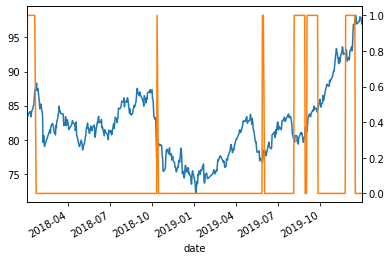

In [22]:
episode = 902
result = plot(train_data, history_evaluate, episode)

C:\Users\user\python\Dueling DQN\3 Act\agent\methods.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result['hold'] = pd.Series(history[episode], data.index)


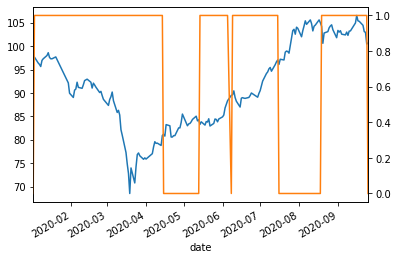

In [27]:
history_test={}
test_profit, history_test[0] = training_evaluate(agent, env2,)    
result = plot(test_data, history_test, 0)

In [ ]:
def load_record():
    
    for k,v in data.loc[:0].items():
    
        if k == 'name':
            name = v[0]
        else:
            exec(k+'='+ str(v[0]))
            
def save_record():
    new_index = data.index[-1]+1
    data.loc[new_index] = 0

    for k in data.columns:

        if k != 'serial':
            exec('data["'+k+'"].loc[new_index] = ' + k )
        else:
            exec('data["'+k+'"].loc[new_index] = ' + k+ '+1' )

    data.to_pickle('record')